In [1]:
import open3d as o3d
import torch
import numpy as np

import objaverse
import multiprocessing

from PIL import Image
import io
from matplotlib import pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# To see visualizations of all step, set True
show_vis = False

In [3]:
tesla_uid = '2c91f1d43c174e1493e29b4a0e6229da'
model_annot = objaverse.load_annotations([tesla_uid])

In [4]:
processes = multiprocessing.cpu_count()
objects = objaverse.load_objects(
    uids=[tesla_uid],
    download_processes=processes
)

In [5]:
model_o3d = o3d.io.read_triangle_mesh(objects[tesla_uid])

In [7]:
if show_vis:
    o3d.visualization.draw_plotly([model_o3d])

In [8]:
# Rotate and Center
rotation_axis_angle = np.array([0, 0, 0])
rot_matrix = o3d.geometry.get_rotation_matrix_from_axis_angle(rotation_axis_angle)

model_o3d.rotate(rot_matrix)
model_bounding_box = model_o3d.get_axis_aligned_bounding_box()

bb_center = model_bounding_box.get_center()
translation_center = np.array([-bb_center[0], -bb_center[1], -model_bounding_box.min_bound[2]])

model_o3d.translate(translation_center)
model_bounding_box.translate(translation_center)

print(model_bounding_box.get_print_info())

[(-1.4521, -1.3093, 0.0000) - (1.4521, 1.3093, 4.5401)]


In [9]:
# Scale
scale_factor = 0.4 / model_bounding_box.max_bound[2]
model_o3d.scale(scale_factor, np.zeros(3))
model_bounding_box.scale(scale_factor, np.zeros(3))

print(model_bounding_box.get_print_info())

[(-0.1279, -0.1154, 0.0000) - (0.1279, 0.1154, 0.4000)]


In [10]:
if show_vis:
    o3d.visualization.draw_plotly([model_o3d])

In [11]:
from os import path

scene = 'scene0000_00'

dataset_path = '/mnt/3dcv/projects/openscene_test/data/scannet/scannet_3d'
scene_path = f'train/{scene}_vh_clean_2.pth'
path = path.join(dataset_path, scene_path)    

scene_array, scene_colors, scene_annot = torch.load(path)

scene_o3d = o3d.geometry.PointCloud()
scene_o3d.points = o3d.utility.Vector3dVector(scene_array)
scene_o3d.colors = o3d.utility.Vector3dVector(scene_colors)

scene_bounding_box = scene_o3d.get_oriented_bounding_box()

In [12]:
filter_annot = -1 # 1 = floor

if filter_annot >= 0:
    indices = (scene_annot == filter_annot)
else:
    indices = np.repeat(True, scene_annot.shape)

filtered_scene_array = scene_array[indices]
filtered_scene_colors = scene_colors[indices]
    
filtered_scene_o3d = o3d.geometry.PointCloud()
filtered_scene_o3d.points = o3d.utility.Vector3dVector(filtered_scene_array)
filtered_scene_o3d.colors = o3d.utility.Vector3dVector(filtered_scene_colors)

In [13]:
if show_vis:
    o3d.visualization.draw_plotly([filtered_scene_o3d])

In [14]:
# Find valid placement, "on top" of relevant points
center_placement = np.array([2.5, 6.])

bb_min = model_bounding_box.get_min_bound()
bb_max = model_bounding_box.get_max_bound()

lower_bound_mask = (center_placement + bb_min[:2] < filtered_scene_array[:, :2]).all(axis=1)
upper_bound_mask = (center_placement + bb_max[:2] > filtered_scene_array[:, :2]).all(axis=1)
bound_mask = lower_bound_mask & upper_bound_mask

assert bound_mask.sum() > 0

max_height = filtered_scene_array[bound_mask][:, 2].max()
model_position = np.concatenate([center_placement, np.array([max_height])])

model_o3d.translate(model_position)
model_bounding_box.translate(model_position)

AxisAlignedBoundingBox: min: (2.37207, 5.88465, 0.507067), max: (2.62793, 6.11535, 0.907067)

In [15]:
# Downsample to fit scene
down_model_o3d = model_o3d.sample_points_uniformly(1000)
down_model_o3d = down_model_o3d.voxel_down_sample(voxel_size=0.05)

if np.asarray(down_model_o3d.colors).size == 0:
    down_model_o3d.paint_uniform_color(np.array([0, 0, 0]))

augmented_scene_array = np.concatenate([np.asarray(scene_o3d.points), np.asarray(down_model_o3d.points)])
augmented_scene_colors = np.concatenate([np.asarray(scene_o3d.colors), np.asarray(down_model_o3d.colors)])

augmented_scene_o3d = o3d.geometry.PointCloud()
augmented_scene_o3d.points = o3d.utility.Vector3dVector(augmented_scene_array)
augmented_scene_o3d.colors = o3d.utility.Vector3dVector(augmented_scene_colors)

In [16]:
if show_vis:
    o3d.visualization.draw_plotly([augmented_scene_o3d])

In [17]:
# http://www.open3d.org/docs/latest/python_example/visualization/index.html#render-to-image-py

scene_img = '2900'

extrinsic_matrix = \
    np.loadtxt(f'/mnt/3dcv/projects/openscene_test/data/scannet/scannet_2d/{scene}/pose/{scene_img}.txt')
    
intrinsic_matrix = \
    np.loadtxt(f'/mnt/3dcv/projects/openscene_test/data/scannet/scannet_2d/intrinsics.txt')

img_path = f'/mnt/3dcv/projects/openscene_test/data/scannet/scannet_2d/{scene}/color/{scene_img}.jpg'
depth_path = f'/mnt/3dcv/projects/openscene_test/data/scannet/scannet_2d/{scene}/depth/{scene_img}.png'

scannet_img = np.asarray(o3d.io.read_image(img_path))
scannet_depth = np.asarray(o3d.io.read_image(depth_path))

img_height, img_width = scannet_depth.shape
render = o3d.visualization.rendering.OffscreenRenderer(img_width, img_height)

[Open3D INFO] EGL headless mode enabled.


In [18]:
render.scene.set_background([1, 1, 1, 0])
render.scene.show_axes(True)

white = o3d.visualization.rendering.MaterialRecord()
white.base_color = [1.0, 1.0, 1.0, 1.0]
white.shader = "defaultLit"

In [19]:
model_o3d.compute_triangle_normals()
model_o3d.compute_vertex_normals()
render.scene.add_geometry("model", model_o3d, white)

In [20]:
#render.setup_camera(intrinsic_matrix[:3, :3], extrinsic_matrix, img_width, img_height)
#render.setup_camera(intrinsic_matrix[:3, :3], cam_transform, img_width, img_height)

vfov = 2 * np.arctan(img_height / (2 * intrinsic_matrix[1, 1]))
eye = extrinsic_matrix[:3, 3]
lookat = eye + (extrinsic_matrix[:3, :3] @ np.array([0, 0, 1]))
up = (extrinsic_matrix[:3, :3] @ np.array([0, -1, 0]))

render.setup_camera(vfov*180/np.pi, lookat, eye, up)

In [21]:
img_model = np.asarray(render.render_to_image())
depth_model = np.asarray(render.render_to_depth_image(z_in_view_space=True))

In [22]:
aug_depth = np.asarray(scannet_depth).copy()
aug_img = np.asarray(scannet_img).copy()
mask = np.all(np.array([aug_depth == 0, depth_model < np.inf]), axis=0)
mask = np.any(np.array([aug_depth > depth_model, mask]), axis=0)

aug_depth[mask] = depth_model[mask]
aug_img[mask] = img_model[mask]

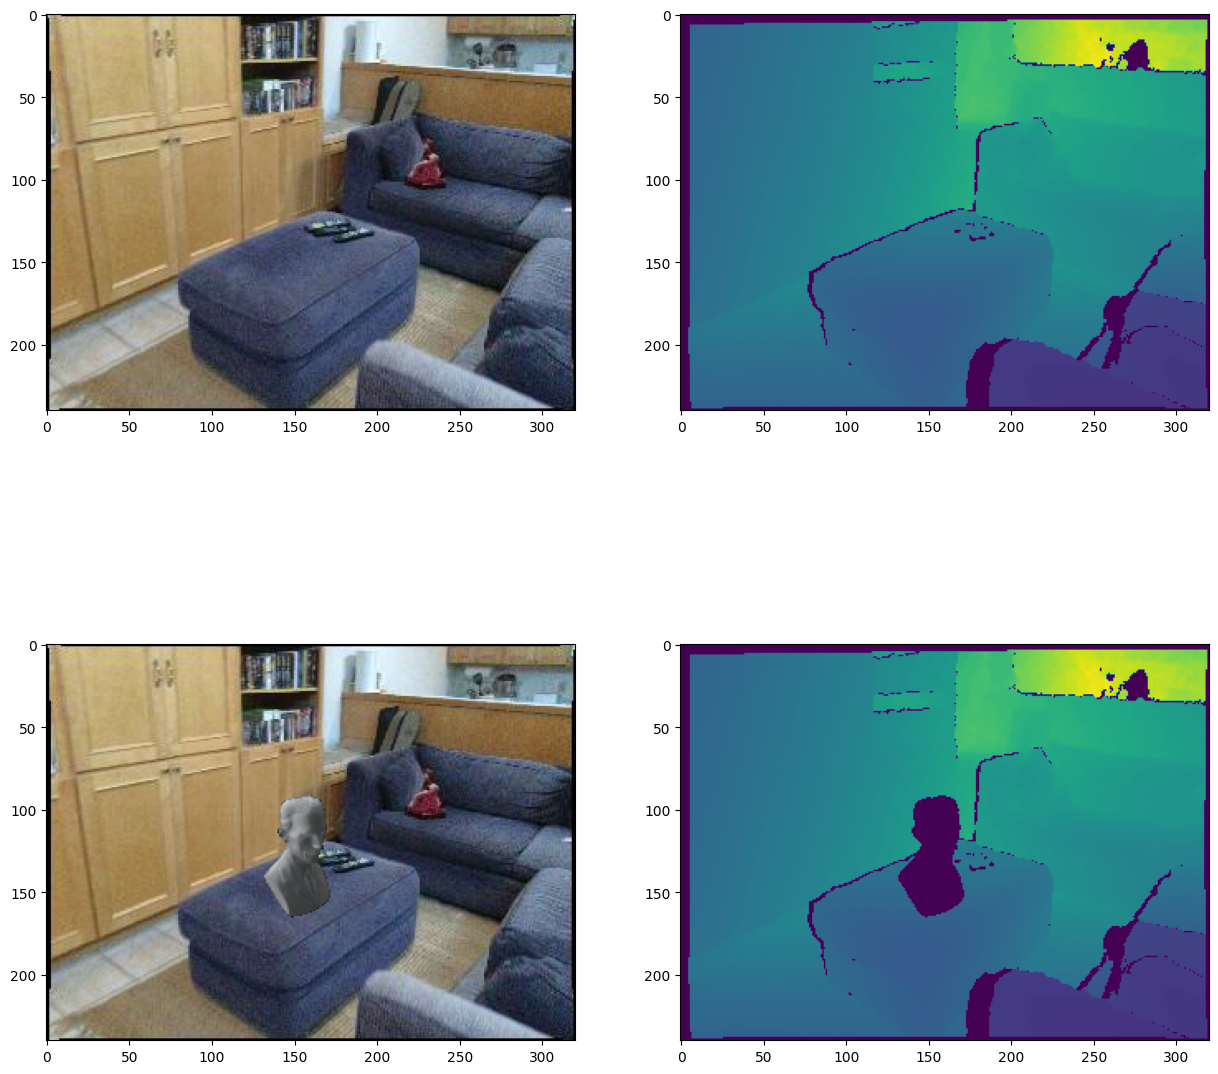

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax[0, 0].imshow(scannet_img)
ax[0, 1].imshow(scannet_depth)
ax[1, 0].imshow(aug_img)
ax[1, 1].imshow(aug_depth)